In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import os
print(tf.config.list_physical_devices('GPU'))

In [2]:
train_path = "/mnt/c/LungCancerCT/CTscans"
data_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.15,
      fill_mode='nearest')

train_generator = data_generator.flow_from_directory(train_path,
                                                    class_mode="binary",
                                                    subset="training",)
validation_generator = data_generator.flow_from_directory(train_path,
                                                    class_mode="binary",
                                                    subset="validation",)

Found 748 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=80,
    validation_data=validation_generator,)


In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)
accuracy_difference = average_train_accuracy - average_val_accuracy

average_train_loss = sum(train_loss) / len(train_loss)
average_val_loss = sum(val_loss) / len(val_loss)

print(f"Average Training Accuracy: {average_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Difference: {accuracy_difference:.4f}")

print(f"Average Training loss: {average_train_loss:.4f}")
print(f"Average Validation loss: {average_val_loss:.4f}")

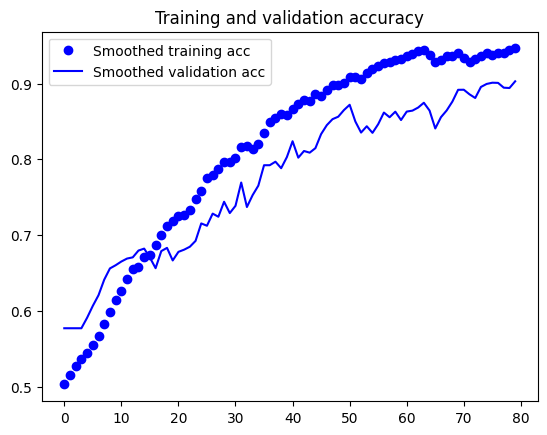

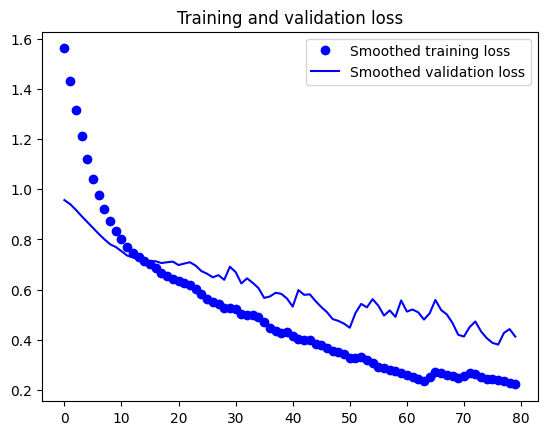

In [5]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
test_path = "/mnt/c/LungCancerCT/final_test_images"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 99 images belonging to 2 classes.
4/4 [==============================] - 1s 276ms/step - loss: 0.1684 - accuracy: 0.9798
test acc: 0.9797979593276978


Found 99 images belonging to 2 classes.
99/99 [==============================] - 1s 10ms/step


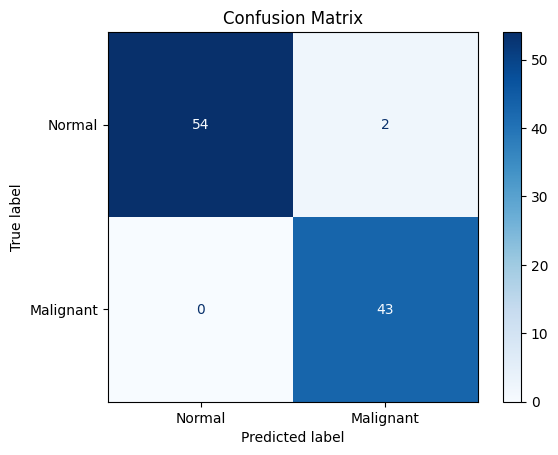

True Negatives (TN): 54 (54.55%)
False Positives (FP): 2 (2.02%)
False Negatives (FN): 0 (0.00%)
True Positives (TP): 43 (43.43%)


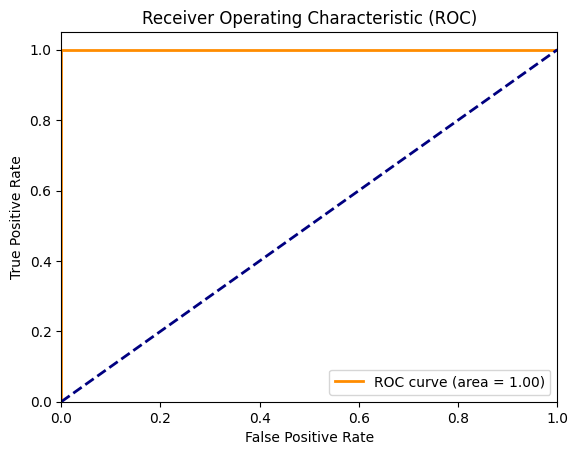

In [7]:
test_path = "/mnt/c/LungCancerCT/final_test_images"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size=1,
    class_mode='binary',
    shuffle=False)

predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

tn_percent = (tn / total) * 100
fp_percent = (fp / total) * 100
fn_percent = (fn / total) * 100
tp_percent = (tp / total) * 100

print(f"True Negatives (TN): {tn} ({tn_percent:.2f}%)")
print(f"False Positives (FP): {fp} ({fp_percent:.2f}%)")
print(f"False Negatives (FN): {fn} ({fn_percent:.2f}%)")
print(f"True Positives (TP): {tp} ({tp_percent:.2f}%)")

fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
